# Welcome to the ATLAS UK (Jan. 2021) ML tutorial!    
## This tutorial will attempt to guide you through a short analysis chain. The general outline of this tutorial is as follows:

1. Setup the workbook environment and download some ATLAS Open Data samples. 
2. Implement some basic selections and make some plots of the kinematic variables.
3. Train a deep neural network to discriminate between the signal process of interest and the major background sample.
4. Test the significance of the discrimination using a cut on the output of the DNN.




## 0. Colab workbook basics
#### *Running cells in Google Colab*: 
1.   Run each cell individually (or stop/restart them) by clicking on the arrow icon on each code cell. Cells marked with a number have been already run.
2.   `Runtime` menu allows you to clear all cells, run all cells etc.

#### *Adding cells in Google Colab*:
Both cells and textboxes can be appended to google colab either by clicking the relevant section and then clicking the "+ Code" button or "+Text"  option above, or by hovering over the bottom of the relevant section/block to see the same options. 

#### *Saving the notebook*
You can save a copy with the updates you make into your own Google Drive area (using "Copy to Drive" or File/Save a copy in Drive"), and there is github integration (unfortunately NOT Gitlab) under the "File/Save to Github".




### 1. Getting the workbook environment set up!
This tutorial makes use of modern HEP software libraries, such as [Uproot4](https://uproot.readthedocs.io/en/latest/), while also leverging tools widely used in data science, such as Pandas, numpy and sklearn. Uproot4 enables us to use ROOT files as inputs to this tutorial, without needing an install of ROOT to hand!    
To get started, set:

```
first_run = True
```

After doing this,*italicised text* run the first two cells. Every time you open this workbook on a new instance of Google Colab, you will need to run this step to install the required packages. 

In [1]:
first_run = True

In [2]:
if first_run:
  print('--- INSTALLING PACKAGES ---')
  !python3 -m pip install --upgrade pip
  !python3 -m pip install grpcio==1.32.0
  !python3 -m pip install tensorflow==2.2.0
  !python3 -m pip install keras
  !python3 -m pip install sklearn
  !python3 -m pip install pydot
  !python3 -m pip install graphviz
  !python3 -m pip install uproot4
  !python3 -m pip install awkward1
  !python3 -m pip install progressbar2
else:
  print('--- SKIPPING INSTALL ---')

--- INSTALLING PACKAGES ---


In addition, we should now download the ATLAS Open Data files that we will use for this tutorial. Again, we should do this when we first run the workbook on an instance of Google Colab. A lot of helpful info about the available ATLAS Open Data samples can be found here: [ATLAS Open Data portal](http://opendata.atlas.cern/release/2020/documentation/).    
You may have noticed that the previous cell and this cell use shell commands. To use standard shell commands, start the line with an exclamation mark. 

In [3]:
if first_run:
  !rm *.root*
  !wget http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_387163.TT_directTT_600_1.1largeRjet1lep.root
  !wget http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_410000.ttbar_lep.1largeRjet1lep.root
  !ls

--2021-01-05 15:10:47--  http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_387163.TT_directTT_600_1.1largeRjet1lep.root
Resolving opendata.cern.ch (opendata.cern.ch)... 188.184.28.138, 188.185.82.144, 2001:1458:d00:e::100:8a, ...
Connecting to opendata.cern.ch (opendata.cern.ch)|188.184.28.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2578131 (2.5M) [application/octet-stream]
Saving to: ‘mc_387163.TT_directTT_600_1.1largeRjet1lep.root’

mc_387163.TT_direct 100%[===================>]   2.46M  2.35MB/s    in 1.0s    

2021-01-05 15:10:49 (2.35 MB/s) - ‘mc_387163.TT_directTT_600_1.1largeRjet1lep.root’ saved [2578131/2578131]

--2021-01-05 15:10:49--  http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_410000.ttbar_lep.1largeRjet1lep.root
Resolving opendata.cern.ch (opendata.cern.ch)... 188.184.28.138, 188.185.82.144, 2001:1458:d00:e::100:8a, ...
Connecting to opendata.cern.ch (

Finally, we will import the relevant modules and functions. We will use Keras, a library which interfaces to TensorFlow, for our deep neural network. 

In [4]:
from keras.optimizers import Adam
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In addition, we will use some sklearn features when preparing our datasets for training and testing. We will make use of Pandas to store the information we extract from the ROOT files, and use matplotlib to make all plots in this notebook. 

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pydot
import graphviz
import matplotlib.pyplot as plt
import uproot4
import awkward1
import numpy as np
import progressbar

### 2. Taking a look at some ROOT files
As mentioned earlier, we will use ATLAS Open Data samples in this notebook. Using two simulated samples, we will look at discriminating a SUSY process from its largest background, top-pair production. 

![]()

In [6]:
stop_file = uproot4.open("mc_387163.TT_directTT_600_1.1largeRjet1lep.root")
top_file = uproot4.open("mc_410000.ttbar_lep.1largeRjet1lep.root")
stop_tree = stop_file['mini']
top_tree = top_file["mini"]

If you would like to see the contents of the input ROOT files, set:
```
print_tree = True
```



In [7]:
print_tree = False
if print_tree:
  stop_tree.show()

To get started, we will apply a loose selection to events, requiring that each event has at least two jets (R=0.4), has exactly one lepton and passes one of the single lepton triggers, and also has exactly one large-R jet.    
To save time, we will use only 20000 events from the top-pair sample. 

In [8]:
cuts = '(jet_n >= 2) * (lep_n == 1) * (trigE + trigM == 1) * (largeRjet_n == 1)' 
events_limit = 20000 

In [9]:
def prepare_dataset( tree ):

  # Retrieve branches from trees in awkward array
  vars = ['met_et','met_phi','jet_pt',
          'jet_phi','jet_eta','lep_pt',
          'lep_eta','lep_phi','largeRjet_n','largeRjet_pt',
          'largeRjet_eta','largeRjet_phi']
  weights = ['mcWeight', 'XSection', 'scaleFactor_PILEUP', 'scaleFactor_ELE',
             'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 
             'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'SumWeights']
  all_vars = vars + weights
  temp_tree = tree.arrays(all_vars, cuts)

  # Define branches of variable length to be flattened
  expand_vars = {'jet_pt': 0, 
                 'jet_phi': 0, 
                 'jet_eta': 0, 
                 'largeRjet_pt': 0, 
                 'largeRjet_phi': 0, 
                 'largeRjet_eta': 0,
                 'lep_pt': 0,
                 'lep_phi': 0,
                 'lep_eta': 0 
                 }

  # Prepare dataframe columns
  columns = []
  temp_df = pd.DataFrame(columns=vars)

  # Fill dataframe
  for index, entry in progressbar.progressbar(enumerate(temp_tree)):
    for var in vars:
      if var in expand_vars:
        temp_df.at[index, var] = float(entry[var][expand_vars[var]])
      else:
        temp_df.at[index, var] = float(entry[var])
    temp_weight = 1.0
    for weight in weights:
      if weight != 'SumWeights':
        temp_weight *= entry[weight]
      else:
        temp_weight /= entry[weight]
    if len(temp_tree) > events_limit:
      temp_weight *= (len(temp_tree)/events_limit)
    temp_df.at[index, 'weight'] = temp_weight
    if index == events_limit:
      break

  for column in temp_df.columns:
    temp_df[column] = pd.to_numeric(temp_df[column])

  return temp_df

In [10]:
def make_plot( sig, bkg, variable, xlow=0, xhigh=1E6, bins=50, norm=True, log=False ):

  np_bins = np.linspace(xlow, xhigh, bins+1)
  plt.gcf().clear()

  plt.hist( sig[variable], bins=np_bins, density=norm, label='Sig', histtype='step' )
  plt.hist( bkg[variable], bins=np_bins, density=norm, label='Bkg', histtype='step' )
  plt.xlabel(variable)
  if log:
    plt.yscale('log')
  plt.grid(False)
  plt.legend(loc='best')
  plt.show()

In [11]:
def calculate_mt(df):

  df['dphi_l1_met'] = np.abs(df['lep_phi'] - df['met_phi'])
  df['mt'] = np.sqrt(2 * df['lep_pt'] * df['met_et'] * (1-np.cos(df['dphi_l1_met'])))
  return df

The input ROOT files have a mixture of data-types inside them, namely floats and vectors of mixed length. However, our DNN requires a 'flat' input, so we must flatten these vectors. The function prepare_dataset performs this iteratively. 

In [12]:
stop_df = prepare_dataset(stop_tree)
top_df = prepare_dataset(top_tree)

| |                           #                    | 4206 Elapsed Time: 0:00:12
| |   #                                           | 19997 Elapsed Time: 0:01:43

In addition to the low-level inputs from the ROOT files, we can construct complex variables, such as the transverse mass. The function calculate_mt adds the transverse mass (mt) variable to the dataframes for both signal and background.

In [13]:
stop_df = calculate_mt(stop_df)
top_df = calculate_mt(top_df)

It would be nice to see some plots of these variables! The function make_plot enables this using matplotlib. 

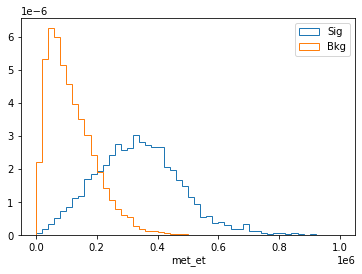

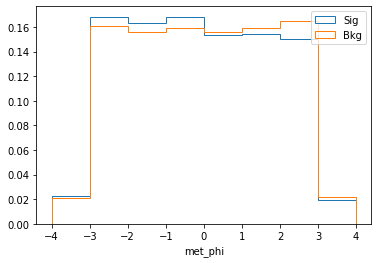

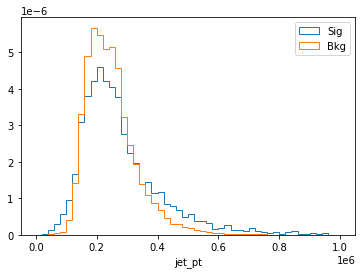

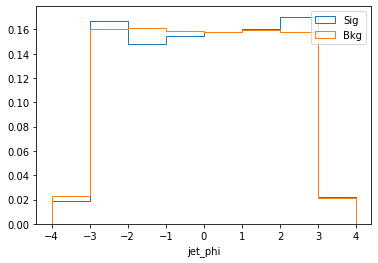

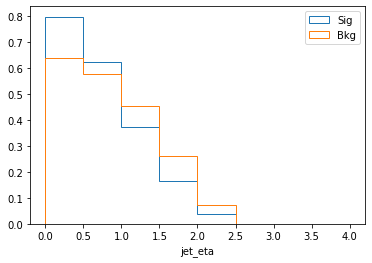

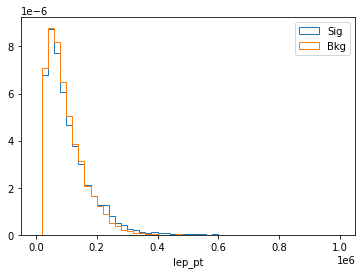

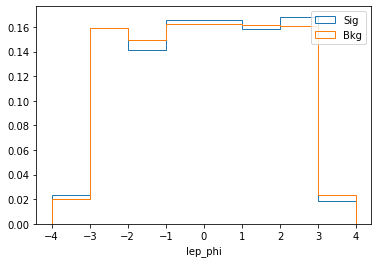

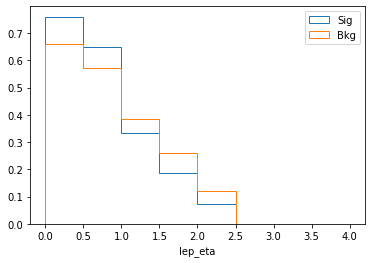

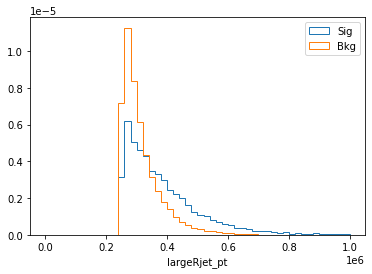

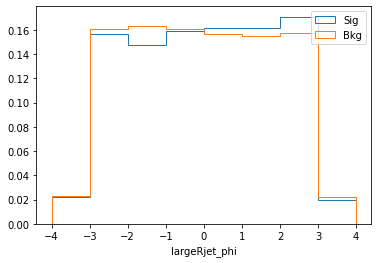

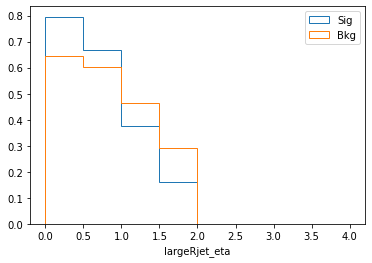

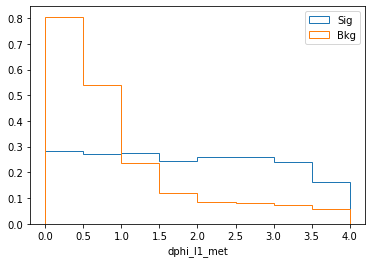

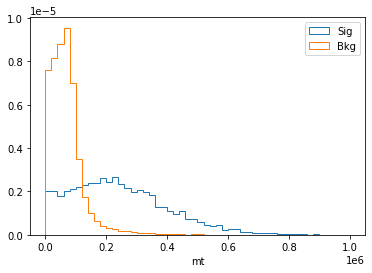

In [14]:
make_plot(stop_df, top_df, 'met_et')
make_plot(stop_df, top_df, 'met_phi', xlow=-4, xhigh=4, bins=8)

make_plot(stop_df, top_df, 'jet_pt')
make_plot(stop_df, top_df, 'jet_phi', xlow=-4, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'jet_eta', xlow=0, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'lep_pt')
make_plot(stop_df, top_df, 'lep_phi', xlow=-4, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'lep_eta', xlow=0, xhigh=4, bins=8)

make_plot(stop_df, top_df, 'largeRjet_pt')
make_plot(stop_df, top_df, 'largeRjet_phi', xlow=-4, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'largeRjet_eta', xlow=0, xhigh=4, bins=8)

make_plot(stop_df, top_df, 'dphi_l1_met', xlow=0, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'mt')

### 3. Steps toward training a DNN.
To perform fully-supervised training, we need to give each of our input classes a label. As we're doing a binary classification, i.e. a this vs that classification, we will give the background the label 0 and the signal the label 1.  


In [15]:
# Set labels for each class
stop_df['class'] = 1
top_df['class'] = 0
# Merge inputs into one dataframe
merge_df = pd.concat([stop_df, top_df])
# Separate the dataframe into one containing the kinematics, and one containing the truth labels. 
X = merge_df.drop(['class', 'weight'], axis=1)
y = merge_df[['class']]

We now use train_test_split to produce independent, randomised samples of events for training and validation. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42 )

The last preparatory step is to scale our features. We need our inputs to be of roughly the same size (order of magnitude), and thus we use a min-max scaler, such that all features are within 0 to 1. 

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Neural networks!

Finally we are getting around to defining our model, which is a neural network. We will use a fully-connected, feed-forward NN. This means that every node in a given layer is connected to all of the nodes in the previous and subsequent layer. 

In [18]:
def model():
    
    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], activation='relu', name='layer_1'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu', name='layer_2'))
    model.add(Dense(10, activation='relu', name='layer_3'))
    model.add(Dense(1, activation='sigmoid', name='output_layer'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

Our model is defined as having an input layer which has the same number of nodes as we do input features. Our output layer has a single output, which will be a number between 0 and 1, corresponding to the prediction of the model for the event. There are 3 hidden layers, which are layers between the input and output layers, and make the neural network a 'deep' neural network.    


#### NN learning rate

Useful parameters to configure: Learning rate
NNs involve configuration of the learning rate (extent to which weights are updated after each back-propagation step/epoch), which is typically taken to be in the range  (0.0,1.0) . The learning rate determines the speed at which the model "learns", such that the larger the learning rate, the faster the model learns at the cost of a somewhat sub-optimal set of parameters and the converse case for the small learning rate.

However, if the learning rates are too large, the weight updates will be too large and will oscillate over training epochs. Conversely if the learning rates are too small, a model may converge to a sub-optimal set of weights.

The Tensorflow default for this parameter is LR=0.01, and we will vary this parameter to LR=0.02 to demonstrate the impact of this parameter.

The exact choice for your use case must be determined by trial and error.

In [37]:
def NNmodel_altLR(activation_function="relu",learningrate=0.02):
  altmodel = Sequential()
  altmodel.add(Dense(8, input_dim=X_train.shape[1], activation='relu', name='layer_1')) # input layer
  altmodel.add(Dense(10, activation=activation_function, name='layer_2'))
  altmodel.add(Dense(10, activation=activation_function, name='layer_3'))
  altmodel.add(Dense(1, activation='sigmoid', name='output_layer')) 
  #configure the optimiser. This is where the learning rate is configured
  opt=Adam(learning_rate=learningrate)
  # can now pass the optimizer we just defined into the model
  altmodel.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
  return altmodel,learningrate


#### Details of the activation function

Activation functions
For each neuron, the output it makes will be of the form Sum(Weight * x) + bias. But, how does one convert this into a more "binary" yes or no statement? So in essence this becomes a function
$Y=f(∑wi∗xi+b)$. 
An initial guess would be a step function (where a neuron was either on/off only). But, this becomes problematic when you have several nodes in a network making decisions. A continuum solution is better, so that "on/off" is replaced with "90% on" etc. This is the role of the activation function, and there are several available. Generally the behaviour that is desired is that it is continuous (or at least piecewise continuous) and piecewise differentiable.

Typically activation functions are plotted on the range [-1,1], and we will discuss a few of these.

One of the simplest classes of activation function is the linear function  $$Y=cx$$  (c non-zero, real), but in such a case, a network consisting of N layers with such a function can be compressed into a single layer with a different constant defined in the activation function. In order to investigate a network with a non-reducible structure, a

A more useful case to binary classification (which has a similar behaviour to the step function) is the sigmoid, defined as:

$$Y=sigmoid(x)=\frac{1}{1+exp(−x)}$$ 
However, the primary issue of the sigmoid function is that for large values of x, the gradient of the activation function is small, which means that the neurons will learn slowly (since the learning process involves minimisation) for large values of x, which is not ideal.

An alternative to the sigmoid is the tanh(x) function defined on range [-1,1].

$$Y=tanh(x)$$ 

which is purely a re-scaled sigmoid, when one considers the hyperbolic identity
$$tanh(u)=2 sigmoid(2u)−1 $$
This function is steeper than the sigmoid across its range of definition, which may improve the speed of learning.

Instead of using the linear activation function, another popular choice of activation function is what is known as "Rectified Linear Units" (ReLU), namely the function:
$$Y=max(0,x).$$ 
Since for nodes with  $x < 0$ , the neuron is not activated (and is effectively discarded), it can greatly reduce computational time by only activating a small subset of nodes (this behaviour is known as sparse activation).

However, for nodes with  $x < 0$ , these nodes are effectively "dead" and weights associated to these nodes cannot be updated/cannot "learn".

Some attempts to rectify this include leaky ReLU(RelU), typically defined as:
Y=max(ax,x),a=0.01 
and exponential linear units (see https://arxiv.org/pdf/1511.07289.pdf)

We will now plot some of these activation functions.

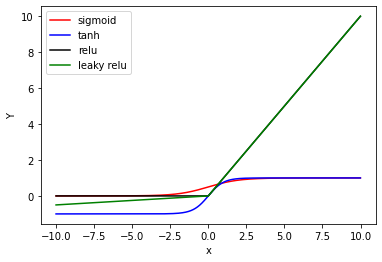

In [20]:
# typically these will be in tensorflow libraries by default
import numpy as np
def sigmoid(x):
  sigmoid=1/(1+np.exp(-x))
  return sigmoid

def ReLU(x):
  if(x>0):
    return x
  else:
    return 0


def LeakyReLU(x):
  if(x>0):
    return x
  else:
    return 0.05*x # effect exaggerated for plot

def PlotActivations():
  #function to show the activation functions discussed above
  
  import matplotlib.pyplot as plt
  range_array=np.arange(-10.0,10.0,0.01)
  y_sigmoid=[]
  y_tanh=[]
  y_RelU=[]
  y_LRelU=[]
  for x in range_array:
    y_sigmoid.append(sigmoid(x))
    y_tanh.append(np.tanh(x))
    y_RelU.append(ReLU(x))
    y_LRelU.append(LeakyReLU(x))

  plt.plot(range_array,y_sigmoid,color='r',label="sigmoid")
  plt.plot(range_array,y_tanh,color='b',label='tanh')
  plt.plot(range_array,y_RelU,color='k',label='relu')
  plt.plot(range_array,y_LRelU,color='g',label="leaky relu")
  plt.xlabel('x')
  plt.ylabel('Y')
  plt.legend()
  return
PlotActivations()

Tensorflow (Keras backend) has several of these activation functions as built-in modules configured by string. The list of available pre-made functions can be found here https://www.tensorflow.org/api_docs/python/tf/keras/activations . Custom configurations are beyond the scope of this tutorial, but documentation can be found here: https://keras.io/api/layers/activations/ 



As you can see, the effect of using ReLU for the hidden layers is that the NN learns faster than that of the NN configured with a sigmoid in the activation function, taking advantage of the sparse activation discussed above, with similar overall performance.

In a real physics use case on large datasets, the CPU/GPU processing time is a major overhead that one must consider when implementing a NN, so fewer epochs to converge = faster.

However, there is no preferred choice of activation functions in a NN, so one must attempt with trial and error.

#### Training our model
We create an instance of our model so that we can train and test it!

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 8)                 120       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 10)                90        
_________________________________________________________________
layer_3 (Dense)              (None, 10)                110       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
None


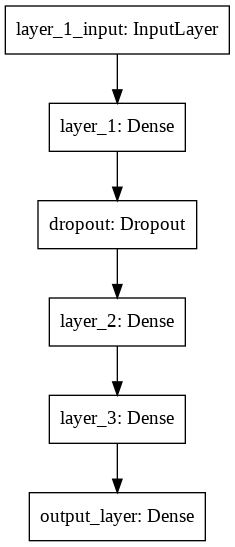

In [21]:
model = model()
print( model.summary() )
plot_model( model )

When training our model, we wish to avoid overtraining - where we specialise our model too much on the training data, and thus lose any discrimination on unseen data. We use early stopping as one way of overcoming this. Early stopping halts the training once one of the training metrics stops improving, in this case the value of the loss function evaluated using the validation data. 

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit( X_train, y_train, epochs=200, batch_size=10, 
                    validation_data=(X_test, y_test), verbose=2, 
                    callbacks=[early_stop] )

Epoch 1/200
1695/1695 - 3s - loss: 0.4057 - accuracy: 0.8508 - val_loss: 0.2879 - val_accuracy: 0.8824
Epoch 2/200
1695/1695 - 3s - loss: 0.3251 - accuracy: 0.8719 - val_loss: 0.2305 - val_accuracy: 0.9251
Epoch 3/200
1695/1695 - 3s - loss: 0.2925 - accuracy: 0.8738 - val_loss: 0.2165 - val_accuracy: 0.9258
Epoch 4/200
1695/1695 - 3s - loss: 0.2760 - accuracy: 0.8753 - val_loss: 0.2168 - val_accuracy: 0.9272
Epoch 5/200
1695/1695 - 3s - loss: 0.2720 - accuracy: 0.8767 - val_loss: 0.2179 - val_accuracy: 0.9279
Epoch 6/200
1695/1695 - 3s - loss: 0.2672 - accuracy: 0.8783 - val_loss: 0.2118 - val_accuracy: 0.9281
Epoch 7/200
1695/1695 - 3s - loss: 0.2593 - accuracy: 0.8926 - val_loss: 0.2138 - val_accuracy: 0.9270
Epoch 8/200
1695/1695 - 3s - loss: 0.2503 - accuracy: 0.8984 - val_loss: 0.2047 - val_accuracy: 0.9284
Epoch 9/200
1695/1695 - 3s - loss: 0.2462 - accuracy: 0.9011 - val_loss: 0.2108 - val_accuracy: 0.9244
Epoch 10/200
1695/1695 - 3s - loss: 0.2436 - accuracy: 0.9016 - val_loss:

We should take a look at some validation plots to ensure the model does not behave much differently for the training and validation sets - this could be a sign of overfitting!

227/227 [==============================] - 0s 1ms/step - loss: 0.2169 - accuracy: 0.9288


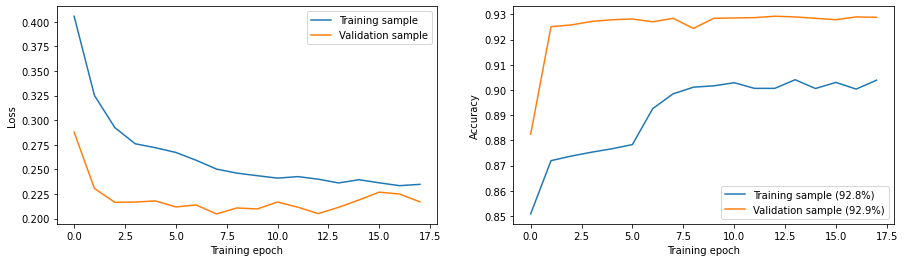

In [23]:
doValidationPlots = True
if doValidationPlots:

  fig, axs = plt.subplots(1,2)
  fig.set_figwidth(15)

  axs[0].plot(history.history['loss'], label='Training sample')
  axs[0].plot(history.history['val_loss'], label='Validation sample')
  axs[0].set_xlabel('Training epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend(loc='best')

  _, training_accuracy = model.evaluate(X_train, y_train)
  _, validation_accuracy = model.evaluate(X_test, y_test)

  axs[1].plot(history.history['accuracy'], label='Training sample ({}%)'.format(round(training_accuracy*100, 1)))
  axs[1].plot(history.history['val_accuracy'], label='Validation sample ({}%)'.format(round(validation_accuracy*100, 1)))
  axs[1].set_xlabel('Training epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend(loc='best')

### 4. Evaluating the performance of our model.
At the end of the analysis chain, we want to test if our DNN gives us discriminatory power. We do this by using the model we trained to predict the class of every event in our samples:





In [24]:
do_predictions = True
if do_predictions:
  bins = np.linspace(0,1,51)

  sig_df = merge_df[merge_df['class'] == 1]
  bkg_df = merge_df[merge_df['class'] == 0]
  sig_weights = sig_df['weight']
  bkg_weights = bkg_df['weight']

  sig_true = scaler.transform(sig_df.drop(['class', 'weight'], axis=1))
  bkg_true = scaler.transform(bkg_df.drop(['class', 'weight'], axis=1))

  sig_preds = model.predict(sig_true)
  bkg_preds = model.predict(bkg_true)

  sig_df['preds'] = sig_preds
  bkg_df['preds'] = bkg_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We now make a plot of these predictions for each class!

Text(0, 0.5, 'Events / bin')

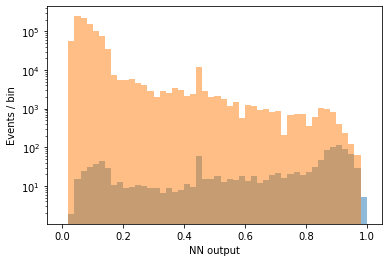

In [25]:
lumi = 139000

plt.hist( sig_preds, bins=bins, alpha=0.5, label='Signal', weights=lumi*sig_weights )
plt.hist( bkg_preds, bins=bins, alpha=0.5, label='Background', weights=lumi*bkg_weights )
plt.yscale('log')
plt.xlabel('NN output')
plt.ylabel('Events / bin')

As we **should** see, the model peaks at low NN output for the background class and at high NN output for the signal class, as we hoped! We can now make a crude estimate of the discriminatory power of our classifier by placing a cut on the output of the NN, and counting the number of signal and background events passing this cut (cut & count). 

In [26]:
cut = 0.95

signal_yield = lumi * sig_df[sig_df['preds'] > 0.95]['weight'].sum()
background_yield = lumi * bkg_df[bkg_df['preds'] > 0.95]['weight'].sum()

print('Signal events: {}'.format(signal_yield))
print('Background events: {}'.format(background_yield))
print('Significance: {}'.format(signal_yield/np.sqrt(background_yield)))

Signal events: 65.84135150097678
Background events: 96.59763967797223
Significance: 6.6990848648751395


In principle, this is an example of an analysis chain using a DNN as the main discriminant. We can now play around with the structure of our DNN and alter the learning rate. In addition, we can change the loose selections applied at the start of the chain and re-run!

## Exercise: Varying number of hidden layers
Try adding and removing hidden layers to see if the *performance* of your network changes.

## Exercise: Evaluating the impact of learning rate on the NN training

Given the model above under "NN learning rate" section and the default model considered, please evaluate the impact of varying the learning rates on the training.

Sample plotting code is added here for the respective plots.

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
# fit our model with the alternative learning rate
NNmodel_altLR,learningrate=NNmodel_altLR(learningrate=0.02)
history_altLR = NNmodel_altLR.fit( X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stop] )
#copy the default fit history from the default NN model
history_reference=history


Epoch 1/200
1695/1695 - 3s - loss: 0.2458 - accuracy: 0.9132 - val_loss: 0.2066 - val_accuracy: 0.9290
Epoch 2/200
1695/1695 - 3s - loss: 0.2194 - accuracy: 0.9249 - val_loss: 0.2157 - val_accuracy: 0.9276
Epoch 3/200
1695/1695 - 3s - loss: 0.2179 - accuracy: 0.9253 - val_loss: 0.2028 - val_accuracy: 0.9263
Epoch 4/200
1695/1695 - 3s - loss: 0.2179 - accuracy: 0.9252 - val_loss: 0.2132 - val_accuracy: 0.9254
Epoch 5/200
1695/1695 - 3s - loss: 0.2125 - accuracy: 0.9275 - val_loss: 0.2165 - val_accuracy: 0.9274
Epoch 6/200
1695/1695 - 3s - loss: 0.2113 - accuracy: 0.9281 - val_loss: 0.2295 - val_accuracy: 0.9225
Epoch 7/200
1695/1695 - 3s - loss: 0.2078 - accuracy: 0.9277 - val_loss: 0.2054 - val_accuracy: 0.9321
Epoch 8/200
1695/1695 - 3s - loss: 0.2094 - accuracy: 0.9294 - val_loss: 0.1954 - val_accuracy: 0.9306
Epoch 9/200
1695/1695 - 3s - loss: 0.2083 - accuracy: 0.9295 - val_loss: 0.2111 - val_accuracy: 0.9320
Epoch 10/200
1695/1695 - 3s - loss: 0.2051 - accuracy: 0.9304 - val_loss:

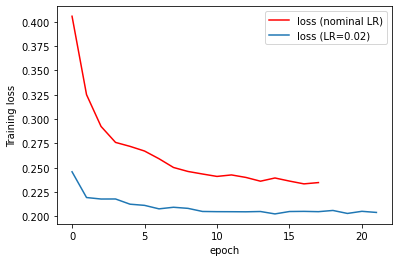

In [28]:
plt.plot(history_reference.history['loss'],label='loss (nominal LR)',color='r')
plt.plot(history_altLR.history['loss'],label='loss (LR={})'.format(learningrate))
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.legend()

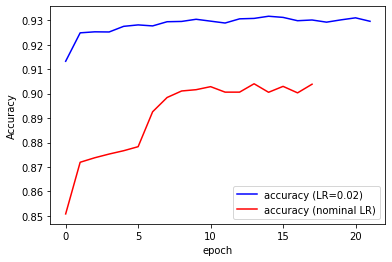

In [29]:
plt.plot(history_altLR.history["accuracy"],label='accuracy (LR={})'.format(learningrate),color='b')
plt.plot(history_reference.history['accuracy'],label='accuracy (nominal LR)',color='r')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

Similarly, try to see how this affects the output classification (if at all!).

##Exercise: Impact of activation functions on the NN training
Change the activation functions in the hidden layer to `'sigmoid'` and compare your results to the default NN configuration.

Some sample code to configure the hidden layers is provided below.

In [30]:
def NNmodel_sigmoid(activation_function="relu"):
  NNmodel = Sequential()
  NNmodel.add(Dense(8, input_dim=X_train.shape[1], activation='relu', name='layer_1')) # input layer
  NNmodel.add(Dense(10, activation=activation_function, name='layer_2'))
  NNmodel.add(Dense(10, activation=activation_function, name='layer_3'))
  NNmodel.add(Dense(1, activation='sigmoid', name='output_layer')) # 
  NNmodel.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return NNmodel

model_sigmoid=NNmodel_sigmoid()
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history_sigmoid = model_sigmoid.fit( X_train, y_train, epochs=200, batch_size=10, 
                                    validation_data=(X_test, y_test), 
                                    verbose=2, callbacks=[early_stop] )
#copy reference history again
history_reference=history

Epoch 1/200
1695/1695 - 3s - loss: 0.3234 - accuracy: 0.8721 - val_loss: 0.2205 - val_accuracy: 0.9237
Epoch 2/200
1695/1695 - 3s - loss: 0.2141 - accuracy: 0.9253 - val_loss: 0.2017 - val_accuracy: 0.9301
Epoch 3/200
1695/1695 - 3s - loss: 0.2069 - accuracy: 0.9274 - val_loss: 0.2068 - val_accuracy: 0.9255
Epoch 4/200
1695/1695 - 3s - loss: 0.2059 - accuracy: 0.9282 - val_loss: 0.2005 - val_accuracy: 0.9294
Epoch 5/200
1695/1695 - 3s - loss: 0.2052 - accuracy: 0.9278 - val_loss: 0.1983 - val_accuracy: 0.9285
Epoch 6/200
1695/1695 - 3s - loss: 0.2039 - accuracy: 0.9295 - val_loss: 0.1977 - val_accuracy: 0.9295
Epoch 7/200
1695/1695 - 3s - loss: 0.2035 - accuracy: 0.9282 - val_loss: 0.1968 - val_accuracy: 0.9284
Epoch 8/200
1695/1695 - 3s - loss: 0.2029 - accuracy: 0.9291 - val_loss: 0.1974 - val_accuracy: 0.9279
Epoch 9/200
1695/1695 - 3s - loss: 0.2023 - accuracy: 0.9296 - val_loss: 0.1959 - val_accuracy: 0.9302
Epoch 10/200
1695/1695 - 3s - loss: 0.2013 - accuracy: 0.9296 - val_loss:

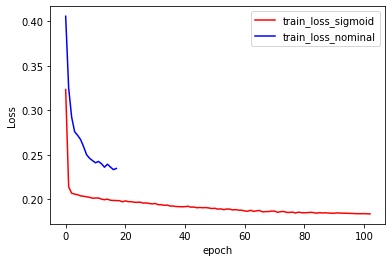

In [36]:
plt.plot(history_sigmoid.history['loss'], label='train_loss_sigmoid',color="r")
plt.plot(history_reference.history['loss'], label='train_loss_nominal',color='b')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

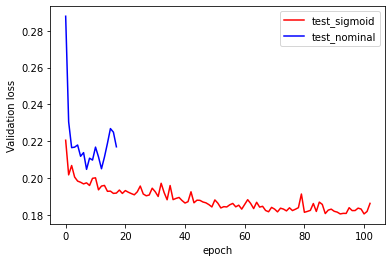

In [35]:
plt.plot(history_sigmoid.history["val_loss"],label='test_sigmoid',color='r')
plt.plot(history_reference.history["val_loss"],label='test_nominal',color='b')
plt.xlabel('epoch')
plt.ylabel('Validation loss')
plt.legend()

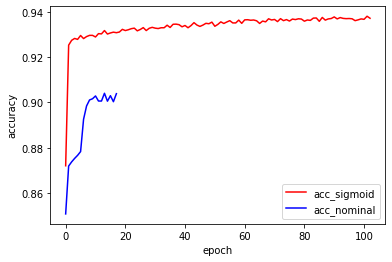

In [34]:
plt.plot(history_sigmoid.history['accuracy'],label='acc_sigmoid',color='r')
plt.plot(history_reference.history['accuracy'],label='acc_nominal',color='b')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

Extension: Do the same exercise again, but with the sigmoid activation function replaced in the output layer with the $tanh$ activation function.